<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [1]:
% matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as sp
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from scipy.stats import norm
from scipy.optimize import curve_fit
from PIL import Image

j = complex(0,1)

# Theory

## Fourier Optics Theory

In fourier optics, the projection of the relationship between the $k$'s of the fourier transform and <i> the actual displacement on the screen </i> is given by

$$ x = \frac{\lambda f}{2 \pi}k $$

where $\lambda$ is the wavelength of the light and $f$ is the focal length of the lens. 

## Digital Fourier Transform Theory

The Fourier Transform is defined as

$$F(w) = \frac{1}{\sqrt{2 \pi}} \int_{- \infty}^{\infty} f(t)e^{-iwt}dt $$

Lets suppose that we are working digitally and have an array of times $t=t_0+n\Delta t$. Summing over all times then yields

$$F(w) = \frac{1}{\sqrt{2 \pi}}\sum_{n=0}^N f(t_0+n\Delta t)e^{-i wt_0}e^{-iwn\Delta t} \Delta t $$

Taking the non-n dependent terms out of the sum yields

$$F(w) = \frac{1}{\sqrt{2 \pi}}\Delta te^{-i wt_0}\sum_{n=0}^N f(t_0+n\Delta t)e^{-iwn\Delta t}  $$

The <b>sum</b> (not the factor out front) is <b> discrete Fourier transform function </b> $F_d (w)$. We can use g=np.fft.fft(f) and  w' = np.fft.fftfreq(f.size) to get arrays of $w'$ and $F(w)$ from

$$F_d(w) = \sum_{n=0}^N f(t_0+n\Delta t)e^{-i (2 \pi n w')}  $$

Notice that the term in the exponential is slightly different. In otherwords, the command np.fft.fftfreq(f.size) returns the array $w'$ and not $w$. We can renormalize the arrays using

$$ w = \frac{2 \pi}{\Delta t}w' $$

$$F =\frac{1}{\sqrt{2 \pi}}\Delta te^{-i wt_0} F_d  $$

We now have an array $F$ which we can plot as a function of $w$. This would yield a plot of the <b> continuous Fourier Transform </b>.

## Combining This Together

Since we normalize the area under the fourier transform, we need not worry about the array $F$ above. Our frequency array $w$ obtained by the fourier transform, however, needs to be multiplied by the following factor in order to correspond to the distances on the screen

$$x=\frac{2 \pi}{\Delta x} \frac{\lambda f}{2 \pi}w=\frac{\lambda f}{\Delta x} w$$

The first term $2\pi/\Delta x$ comes from the digital fourier transform properties; the second term $\lambda f/2\pi$ makes the $k$ space vectors correspond to actual distances on the screen, as explained in the Fourier Optics Theory section.

# Constants of the Experiment

In [2]:
lam = 655e-9
f = 200e-3

Pix_Size = 6.45e-6
X_Pixels = 1360
Y_Pixels = 1024

S_WIDTH = 0
SQUARE_WIDTH_X = 0
SQUARE_WIDTH_Y = 0

# Functions Used in this Code

Opens up a bitmap image and determines the physical dimensions based on the pixel size of the camera defined above.

In [3]:
def get_image_dimensions(image):
    y_width, x_width = image.shape
    x_arr = np.linspace(1, x_width, x_width) *Pix_Size
    y_arr = np.linspace(1, y_width, y_width) *Pix_Size
    
    return x_arr, y_arr, image

Determines the physical dimensions of Fourier Optic System Fourier Transform (dimensions of the image on the back focal plane-theory discussed in theory section).

In [4]:
def get_simulation_dimensions(f_trans):
    ky_width, kx_width = f_trans.shape
    
    del_x = Pix_Size
    del_y = Pix_Size
    
    kx_arr = np.linspace(0, 1, kx_width)*(lam*f/del_x)
    ky_arr = np.linspace(0, 1, ky_width)*(lam*f/del_y)
    
    return kx_arr, ky_arr, f_trans

Sinc is the theoretical Fourier transform of an aperture function so we use it for curve fitting.

In [5]:
def sinc(x, a, R, b):
    return a*np.abs(np.sinc(R*(x-b)))


Removes the baseline from camera images (possibly due to ambient light).

In [6]:
def remove_baseline(im, n=20):
    baseline = im[0][0:n].mean()
    return im-baseline

Converts a bitmap image to a normalized numpy array (total intensity = 1).

In [7]:
def image_to_array(name):
    im = Image.open(name).convert('L')
    p = np.array(im)
    p = remove_baseline(p)
    p = p/p.sum()
    return p

2d Fourier transform on a 2d numpy array.

In [8]:
def simulate_Fourier_2d(array):
    g=np.abs(np.fft.fft2(array))
    g = g/g.sum() #nomralize
    G = np.fft.fftshift( g ) #shift to small frequencies in the middle
    return np.abs(G) #returns intensity

Scales the Axis of a 1D Plot (useful for unit conversion-plotting in mm instead of m)

In [9]:
def scale_axis(ax, scale):
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale))
    ax.xaxis.set_major_formatter(ticks_x)

Scales the Axis of a 2D Plot

In [10]:
def scale_axis_2d(ax, scale):
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*scale))
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(y*scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ax.yaxis.set_major_formatter(ticks_x)

Used to plot the image and the X and Y Profiles (also some nice titles and axis labels and other features).

In [11]:
def plot_image(Image, ax1, ax2, ax3):
    
    x, y, z = get_image_dimensions(Image)
    ax1.pcolor(x, y, z)
    ax1.set_title('Image of Interest')
    ax1.set_ylabel('Distance (mm)')
    ax1.set_xlabel('Distance (mm)')
    scale_axis_2d(ax1, 1000)
    
    
    hx, hy = z.sum(axis=0), z.sum(axis=1)
    (x1, x2, err_x1, err_x2) = find_width(x, hx)
    (y1, y2, err_y1, err_y2) = find_width(y, hy)
    
    SQUARE_WIDTH_X = x2-x1
    SQUARE_WIDTH_Y = y2-y1
    err_SQUARE_WIDTH_X = np.sqrt((err_x1**2+err_x2**2))
    err_SQUARE_WIDTH_Y = np.sqrt((err_y1**2+err_y2**2))
      
    ax2.plot(x, hx)
    ax2.axvline(x = x1, color = 'k', linestyle = '--')
    ax2.axvline(x = x2, color = 'k', linestyle = '--')
    ax2.axvspan(x1-err_x1, x1+err_x1, facecolor='0.5', alpha=0.4)
    ax2.axvspan(x2-err_x2, x2+err_x2, facecolor='0.5', alpha=0.4)
    
    ax3.plot(y, hy)
    ax3.axvline(x = y1, color = 'k', linestyle = '--')
    ax3.axvline(x = y2, color = 'k', linestyle = '--')
    ax3.axvspan(y1-err_y1, y1+err_y1, facecolor='0.5', alpha=0.4)
    ax3.axvspan(y2-err_y2, y2+err_y2, facecolor='0.5', alpha=0.4)
    
    ax2.set_title('X Profile')
    ax2.set_xlabel('Distance (mm)')
    ax2.set_ylabel('Intensity [arb]')
    scale_axis(ax2, 1000)

    ax3.set_title('Y Profile')
    ax3.set_xlabel('Distance (mm)')
    ax3.set_ylabel('Inetnsity [arb]')    
    scale_axis(ax3, 1000)
    
    return (SQUARE_WIDTH_X, SQUARE_WIDTH_Y, err_SQUARE_WIDTH_X, err_SQUARE_WIDTH_Y)

Plots the Fourier Transforms and the curve fits for the X and Y profiles (all nicely oriented on three different axes).

In [12]:
def plot_image_and_fit(Image, ax1, ax2, ax3, image_type):
    
    if image_type is 'image':
        x, y, z = get_image_dimensions(Image)
    if image_type is 'simulation':
        x, y, z = get_simulation_dimensions(Image)
    ax1.pcolor(x, y, z)
    ax1.set_title('Image of Interest')
    ax1.set_ylabel('Distance (mm)')
    ax1.set_xlabel('Distance (mm)')
    scale_axis_2d(ax1, 1000)
    
    hx, hy = z.sum(axis=0), z.sum(axis=1)
    
    # X DATA ---
    
    # Get Sinc Curve Fit Parameters
    (a, R, b), pcov = curve_fit(sinc, x, hx, p0=(np.amax(hx), SQUARE_WIDTH_X/(lam*f), x[np.argmax(hx)]))
    (Rx, err_Rx) = (R, np.diag(pcov)[1])
    
    # Do Plotting
    ax2.plot(x, hx, label='Data')
    ax2.plot(x, sinc(x, a, R, b), color='r', label='Sinc Fit')
    ax2.set_xlim(b-10/R, b+10/R)
    ax1.set_xlim(b-10/R, b+10/R)
    
    # X DATA END ---
    
    # Y DATA ---
    
    # Get Sinc Curve Fit Parameters
    (a, R, b), pcov = curve_fit(sinc, y, hy, p0=(np.amax(hy), SQUARE_WIDTH_Y/(lam*f), y[np.argmax(hy)]))
    (Ry, err_Ry) = (R, np.diag(pcov)[1])
    
    # Do Plotting
    ax3.plot(y, hy, label='Data')
    ax3.plot(y, sinc(y, a, R, b), color='r', label='Sinc Fit')
    ax3.set_xlim(b-10/R, b+10/R)
    ax1.set_ylim(b-10/R, b+10/R)
    
    # Y DATA END ---
    
    # SET TITLES AND LEGENDS
    ax2.set_title('X Profile')
    ax2.set_xlabel('Distance (mm)')
    ax2.set_ylabel('Intensity [arb]')
    scale_axis(ax2, 1000)

    ax3.set_title('Y Profile')
    ax3.set_xlabel('Distance (mm)')
    ax3.set_ylabel('Intensity [arb]')    
    scale_axis(ax3, 1000)
    
    ax2.legend(loc = 'best')
    ax3.legend(loc = 'best')
    
    return (Rx, Ry, err_Rx, err_Ry)

Finds the approximate width of the square by finding both an upper and lower bound, and the value in the middle (upper and lower bound used for drawing error bars on plots).

In [13]:
def find_width(x, hx):
    max_hx = max(hx)
    for i, h in enumerate(hx):
        if h>max_hx/2:
            left_max = x[i]
            break
    for i, h in enumerate(reversed(hx)):
        if h>max_hx/2:
            right_min = np.flip(x, 0)[i]
            break
    for i, h in enumerate(hx):
        if h>max_hx/10:
            left_min = x[i]
            break
    for i, h in enumerate(reversed(hx)):
        if h>max_hx/10:
            right_max = np.flip(x, 0)[i]
            break
    
    left = (left_min+left_max)/2
    right = (right_min+right_max)/2
    err_left = (left_max-left_min)/2
    err_right = (right_max-right_min)/2
            
    return (left, right, err_left, err_right)

# Plotting

## Open Image

In [14]:
Image_Raw = image_to_array("Fourier_Oct_10/Squaretwo/Image_Raw.bmp")

## Plot Image

<IPython.core.display.Javascript object>


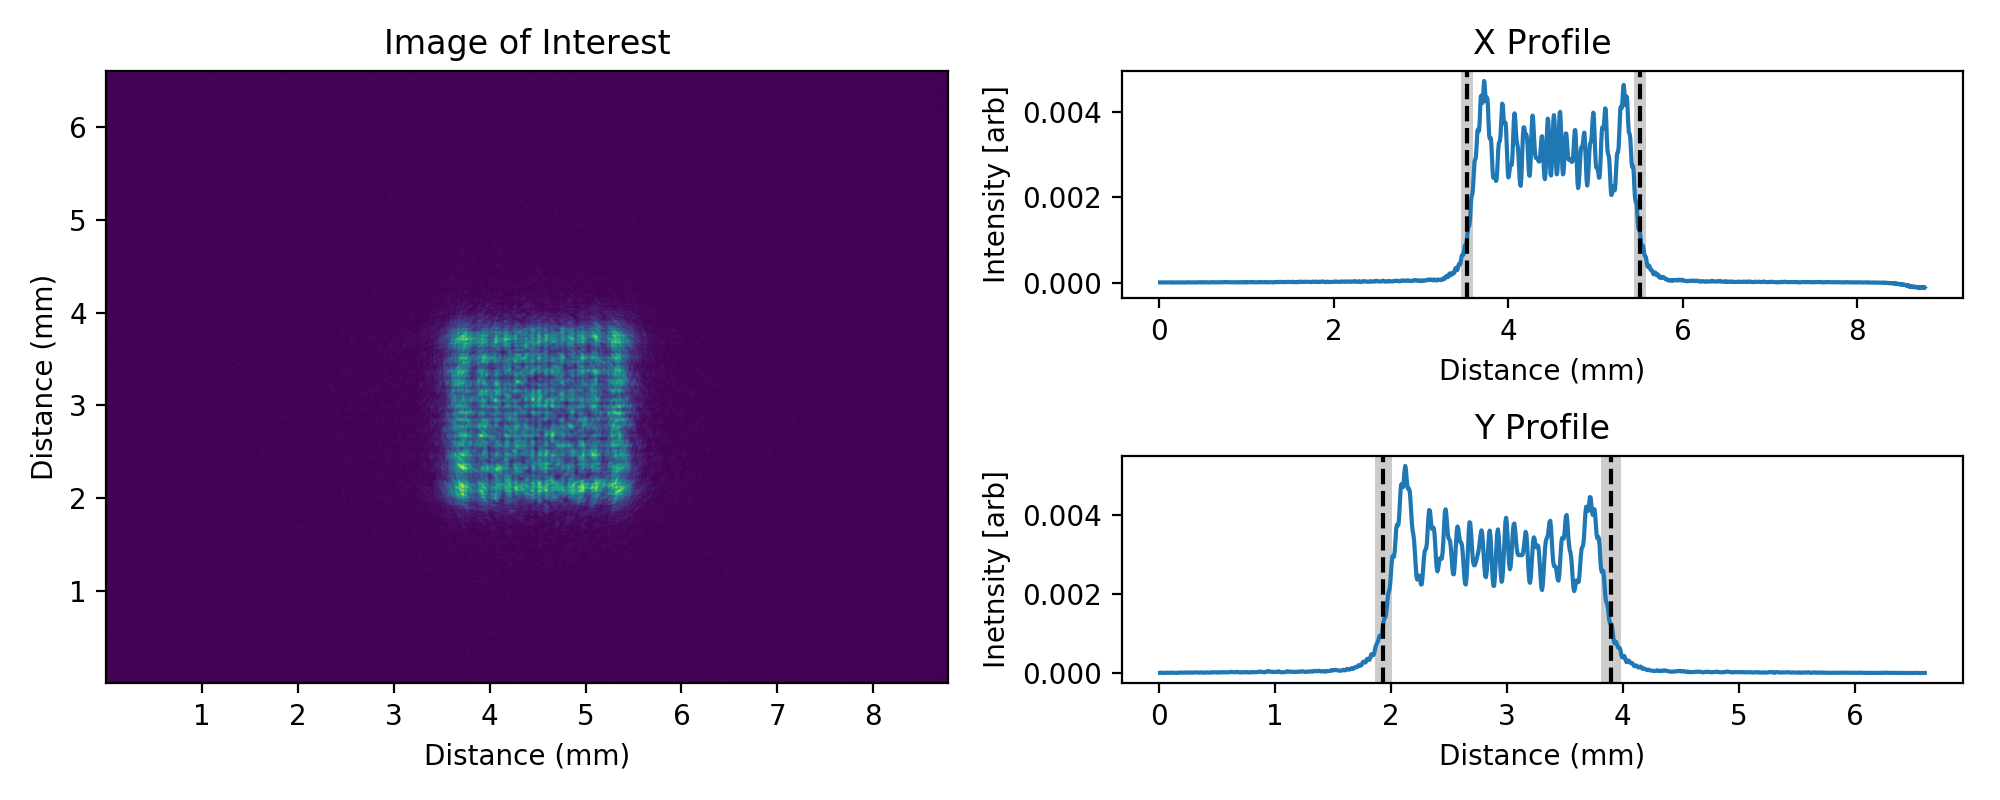

In [26]:
fig = plt.figure(figsize = (10,4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

SQUARE_WIDTH_X, SQUARE_WIDTH_Y, err_S_W_X, err_S_W_Y = plot_image(Image_Raw, ax1, ax2, ax3)

fig.tight_layout()
plt.show()

In [16]:
print('The x width of the square is {}mm'.format(SQUARE_WIDTH_X*1000))
print('The y width of the square is {}mm'.format(SQUARE_WIDTH_Y*1000))

The x width of the square is 1.98015mm
The y width of the square is 1.9640250000000004mm


## Simulate Fourier Transform on Image

In [17]:
Fourier_Raw_Simulate = simulate_Fourier_2d(Image_Raw)

## Open Actual Fourier Transform on Image

In [18]:
Fourier_Raw_Actual = image_to_array("Fourier_Oct_10/Squaretwo/Fourier_Raw(sat).bmp")

## Plot Observed

<IPython.core.display.Javascript object>


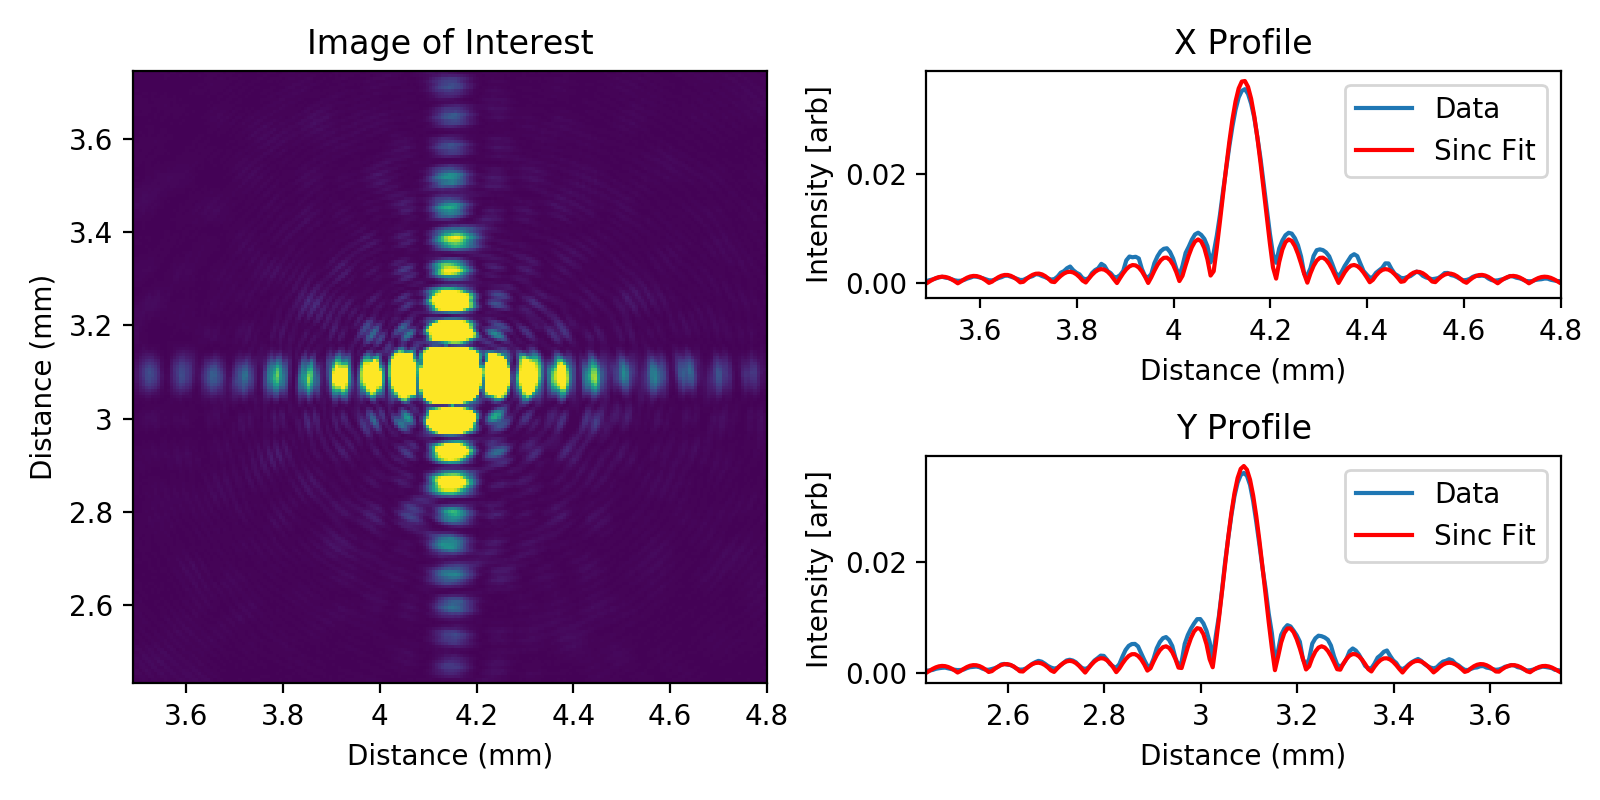

In [19]:
fig = plt.figure(figsize = (8,4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

(Rx_obs, Ry_obs, err_Rx_obs, err_Ry_obs) = plot_image_and_fit(Fourier_Raw_Actual, ax1, ax2, ax3, 'image')

fig.tight_layout()
plt.show()

In [20]:
print('The value of R_x is {} with standard error {}'.format(Rx_obs, err_Rx_obs))
print('The value of R_y is {} with standard error {}'.format(Ry_obs, err_Ry_obs))

The value of R_x is 15248.947026112623 with standard error 46.45250735806993
The value of R_y is 15201.336612922973 with standard error 64.60567780653308


## Plot Simulated

<IPython.core.display.Javascript object>


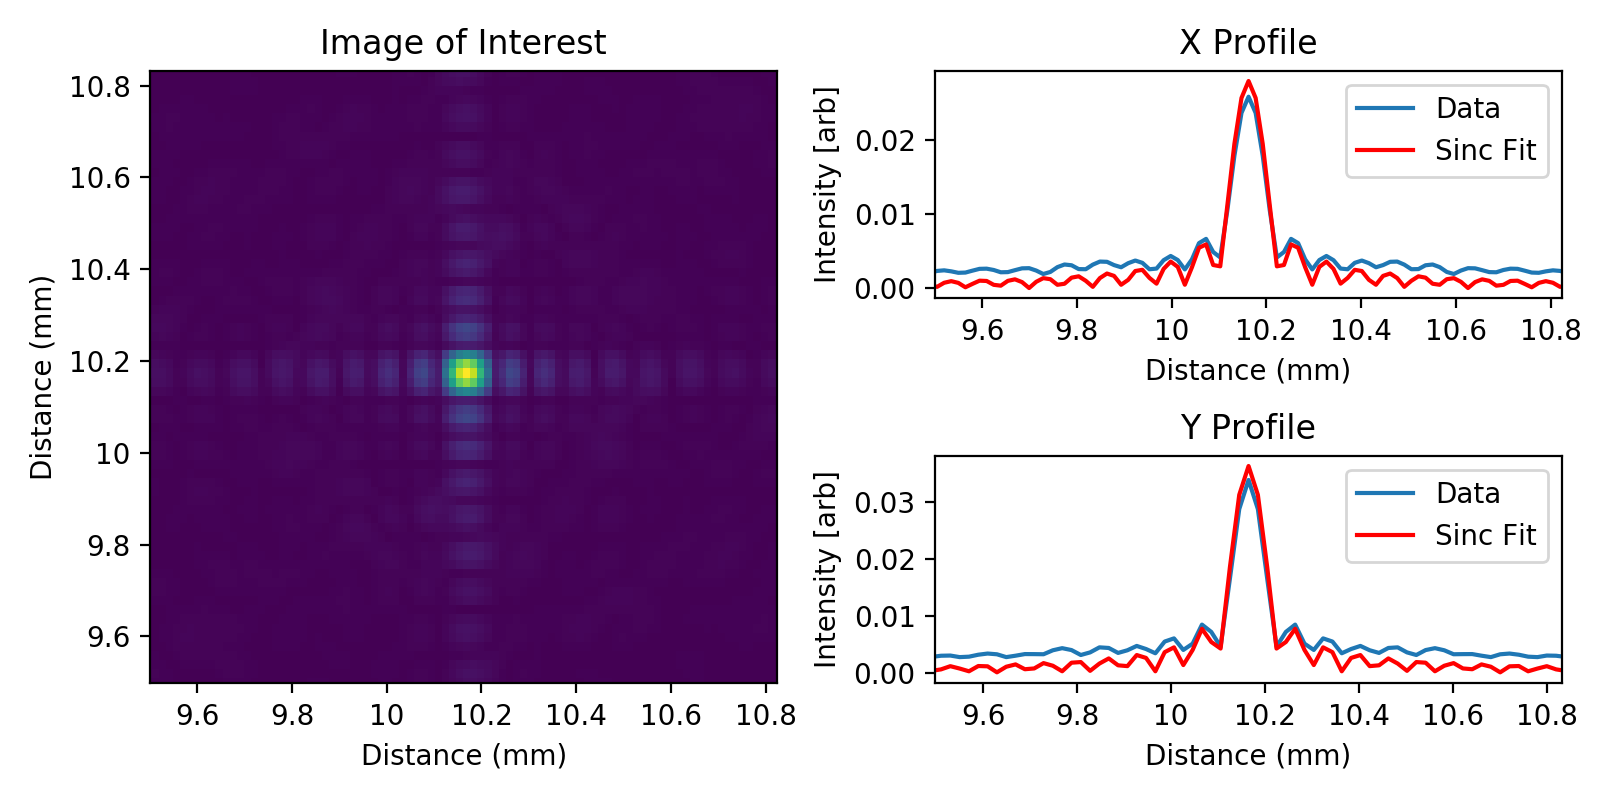

In [21]:
fig = plt.figure(figsize = (8,4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(222)
ax3 = plt.subplot(224)

(Rx_sim, Ry_sim, err_Rx_sim, err_Ry_sim) = plot_image_and_fit(Fourier_Raw_Simulate, ax1, ax2, ax3, 'simulation')

fig.tight_layout()
plt.show()

In [22]:
print('The value of R_x is {} with standard error {}'.format(Rx_sim, err_Rx_sim))
print('The value of R_y is {} with standard error {}'.format(Ry_sim, err_Ry_sim))

The value of R_x is 15115.021923244993 with standard error 200.13484012117019
The value of R_y is 14979.078647558283 with standard error 279.6869514633169


# Do Statistics

In [23]:
from uncertainties import ufloat

## Actual Square Width

In [29]:
WIDTH_X = ufloat(SQUARE_WIDTH_X, err_S_W_X)
WIDTH_Y = ufloat(SQUARE_WIDTH_Y, err_S_W_Y)
print('The Observed X Width of the Square is {}mm'.format(WIDTH_X*1000))
print('The Observed Y Width of the Square is {}mm'.format(WIDTH_Y*1000))

The Observed X Width of the Square is 1.98+/-0.10mm
The Observed Y Width of the Square is 1.96+/-0.11mm


## Fourier Transform Analysis

In [25]:
Rx_sim = ufloat(Rx_sim, err_Rx_sim)
Ry_sim = ufloat(Ry_sim, err_Ry_sim)
Rx_obs = ufloat(Rx_obs, err_Rx_obs)
Ry_obs = ufloat(Ry_obs, err_Ry_obs)
print('The X Width of the Square Based on Simulation is {}mm'.format(lam*f*Rx_sim*1000))
print('The Y Width of the Square Based on Simulation is {}mm'.format(lam*f*Ry_sim*1000))
print('The X Width of the Square Based on Observation is {}mm'.format(lam*f*Rx_obs*1000))
print('The Y Width of the Square Based on Observation is {}mm'.format(lam*f*Ry_obs*1000))

The X Width of the Square Based on Simulation is 1.980+/-0.026mm
The Y Width of the Square Based on Simulation is 1.96+/-0.04mm
The X Width of the Square Based on Observation is 1.998+/-0.006mm
The Y Width of the Square Based on Observation is 1.991+/-0.008mm
